### **CNN Project**

**Title: Bird Songs Classification Using CNNs**

Student Name: Thendral Balakrishnan

Student ID: 24128902

Dataset Link: https://www.kaggle.com/datasets/rtatman/british-birdsong-dataset?resource=download

###Imports

In [26]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D
from keras.layers import BatchNormalization
from sklearn.metrics import accuracy_score
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Input


###Utility Functions

In [27]:
def load_data(data_path, metadata_path):
    features = []
    labels = []

    metadata = pd.read_csv(metadata_path)

    for _, row in metadata.iterrows():
        file_path = os.path.join(data_path, f"xc{row['file_id']}.flac")

        # Check if the file exists before attempting to load it
        if not os.path.exists(file_path):
            print(f"Warning: File not found: {file_path}")  # Print a warning if the file doesn't exist
            continue  # Skip to the next file

        # Load the audio file and resample it
        target_sr = 22050
        audio, sample_rate = librosa.load(file_path, sr=target_sr)

        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=audio, sr=target_sr, n_mfcc=40)
        mfccs_scaled = np.mean(mfccs.T, axis=0)

        # Append features and labels
        features.append(mfccs_scaled)
        labels.append(row['genus'])

    return np.array(features), np.array(labels)

In [33]:
def make_predictions(model, le, file_path):
    audio, sample_rate = librosa.load(file_path, sr=22050)
    mfccs = librosa.feature.mfcc(y=audio, sr=22050, n_mfcc=40)
    mfccs_scaled = np.mean(mfccs.T, axis=0)
    features = mfccs_scaled.reshape(1, mfccs_scaled.shape[0], 1)
    predicted_vector = model.predict(features)
    predicted_class_index = np.argmax(predicted_vector, axis=-1)
    return le.inverse_transform(predicted_class_index)[0]

In [34]:
def train_CNN(model, X_train, y_train, X_test, y_test, epochs=30, batch_size=16, lr=0.001,rmsprop=False):
    if rmsprop:
      model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=lr), metrics=['accuracy'])
    else:
      model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=lr), metrics=['accuracy'])
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Fit the model and collect history
    history = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_test, y_test),
        verbose=1,
    )

    # Evaluate the model on the test set
    _, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Accuracy on test set: {accuracy}")

    final_train_accuracy = history.history['accuracy'][-1]
    final_test_accuracy = history.history['val_accuracy'][-1]

    # Plot accuracy for each epoch
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy')
    plt.legend()
    plt.show()

    model.summary()

    return final_train_accuracy, final_test_accuracy



###CNN Architectures

In [29]:
def CNN_1D(X_train, y_train):
  input_shape = (X_train.shape[1], 1)
  num_classes = y_train.shape[1]
  model = Sequential()
  model.add(Conv1D(64, 3, padding='same', activation='relu', input_shape=input_shape))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.25))
  model.add(Conv1D(128, 3, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))

  return model


In [30]:
def alexNet(X_train, y_train):
  input_shape = (X_train.shape[1], 1)
  model=keras.models.Sequential([
      keras.layers.Conv1D(filters=128, kernel_size=5, strides=1, activation='relu', input_shape=input_shape),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPooling1D(pool_size=2,strides=1),
      keras.layers.Conv1D(filters=256, kernel_size=5, strides=1, activation='relu', padding="same"),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPool1D(pool_size=2),
      keras.layers.Conv1D(filters=256, kernel_size=3, strides=1, activation='relu', padding="same"),
      keras.layers.BatchNormalization(),
      keras.layers.Conv1D(filters=256, kernel_size=1, strides=1, activation='relu', padding="same"),
      keras.layers.BatchNormalization(),
      keras.layers.Conv1D(filters=256, kernel_size=1, strides=1, activation='relu', padding="same"),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPool1D(pool_size=2,strides=1),
      keras.layers.Flatten(),
      keras.layers.Dense(1024,activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1024,activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(y_train.shape[1],activation='softmax')


  ])

  return model

In [31]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4):
  # Input:
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

  # 1st path:
  path1 = Conv1D(filters=f1, kernel_size = 1, padding = 'same', activation = 'relu')(input_layer)

  # 2nd path
  path2 = Conv1D(filters = f2_conv1, kernel_size = 1, padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv1D(filters = f2_conv3, kernel_size = 3, padding = 'same', activation = 'relu')(path2)

  # 3rd path
  path3 = Conv1D(filters = f3_conv1, kernel_size = 1, padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv1D(filters = f3_conv5, kernel_size = 5, padding = 'same', activation = 'relu')(path3)

  # 4th path
  path4 = MaxPooling1D(3, strides= 1, padding = 'same')(input_layer)
  path4 = Conv1D(filters = f4, kernel_size = 1, padding = 'same', activation = 'relu')(path4)

  output_layer = concatenate([path1, path2, path3, path4], axis = -1)

  return output_layer


In [32]:
def GoogLeNet(X_train, y_train):
    input_shape = (X_train.shape[1], 1)
    input_layer = Input(shape=input_shape)

    # Initial Conv1D layer with reduced filter size
    x = Conv1D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu')(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2, strides=1, padding='same')(x)  # Reduced pool size

    # Second Convolution and Pooling
    x = Conv1D(filters=64, kernel_size=1, padding='same', activation='relu')(x)
    x = Conv1D(filters=192, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2, strides=1, padding='same')(x)  # Reduced pool size

    # Inception Blocks
    x = Inception_block(x, 64, 96, 128, 16, 32, 32)
    x = Inception_block(x, 128, 128, 192, 32, 96, 64)
    x = MaxPooling1D(pool_size=2, strides=1, padding='same')(x)  # Pooling after inception blocks

    # Additional Inception Blocks
    x = Inception_block(x, 192, 96, 208, 16, 48, 64)
    x = Inception_block(x, 160, 112, 224, 24, 64, 64)
    x = Inception_block(x, 128, 128, 256, 24, 64, 64)
    x = Inception_block(x, 112, 144, 288, 32, 64, 64)
    x = Inception_block(x, 256, 160, 320, 32, 128, 128)
    x = MaxPooling1D(pool_size=2, strides=1, padding='same')(x)  # Pooling after additional inception blocks

    # Further Inception Blocks
    x = Inception_block(x, 256, 160, 320, 32, 128, 128)
    x = Inception_block(x, 384, 192, 384, 48, 128, 128)

    # Fully Connected Layers

    x = Flatten()(x)
    x = Dropout(0.4)(x)
    x = Dense(y_train.shape[1], activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=x)

    return model


###Data Augmentation Function

In [28]:
def augment_data(features, labels):
    augmented_features = []
    augmented_labels = []
    print("Features shape before augmentation:", features.shape)
    print("Labels shape before augmentation:", labels.shape)

    for feature, label in zip(features, labels):
        augmented_features.append(feature)
        augmented_labels.append(label)

        # Add noise
        noise = np.random.normal(0, 0.01, feature.shape[0])
        augmented_features.append(feature + noise)
        augmented_labels.append(label)

        # Time stretching
        stretch_factor = random.uniform(0.9, 1.1)
        n_fft_value = 2048

        # Reshape to 1D for time_stretch
        feature_1d = feature.reshape(1, -1)

        stretched_audio = librosa.effects.time_stretch(librosa.istft(feature_1d, n_fft=n_fft_value), rate=stretch_factor)
        stretched_mfccs = librosa.feature.mfcc(y=stretched_audio, sr=22050, n_mfcc=40)
        stretched_mfccs_scaled = np.mean(stretched_mfccs.T, axis=0)
        augmented_features.append(stretched_mfccs_scaled)
        augmented_labels.append(label)

    print("Augmented features shape:", np.array(augmented_features).shape)
    print("Augmented labels shape:", np.array(augmented_labels).shape)

    return np.array(augmented_features), np.array(augmented_labels)

In [35]:
data_path = "/content/drive/MyDrive/MSc Artificial Intelligence and Machine Learning/CNN Project/birdsongs/songs/songs"
metadata_path = "/content/drive/MyDrive/MSc Artificial Intelligence and Machine Learning/CNN Project/birdsongs/birdsong_metadata.csv"
features, labels = load_data(data_path, metadata_path)

# Encode labels
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_onehot = to_categorical(labels_encoded)

X_train, X_test, y_train, y_test = train_test_split(features, labels_onehot, test_size=0.3, random_state=42, stratify=labels_onehot)


###Visualizing the Data Distribution across different Bird Genera

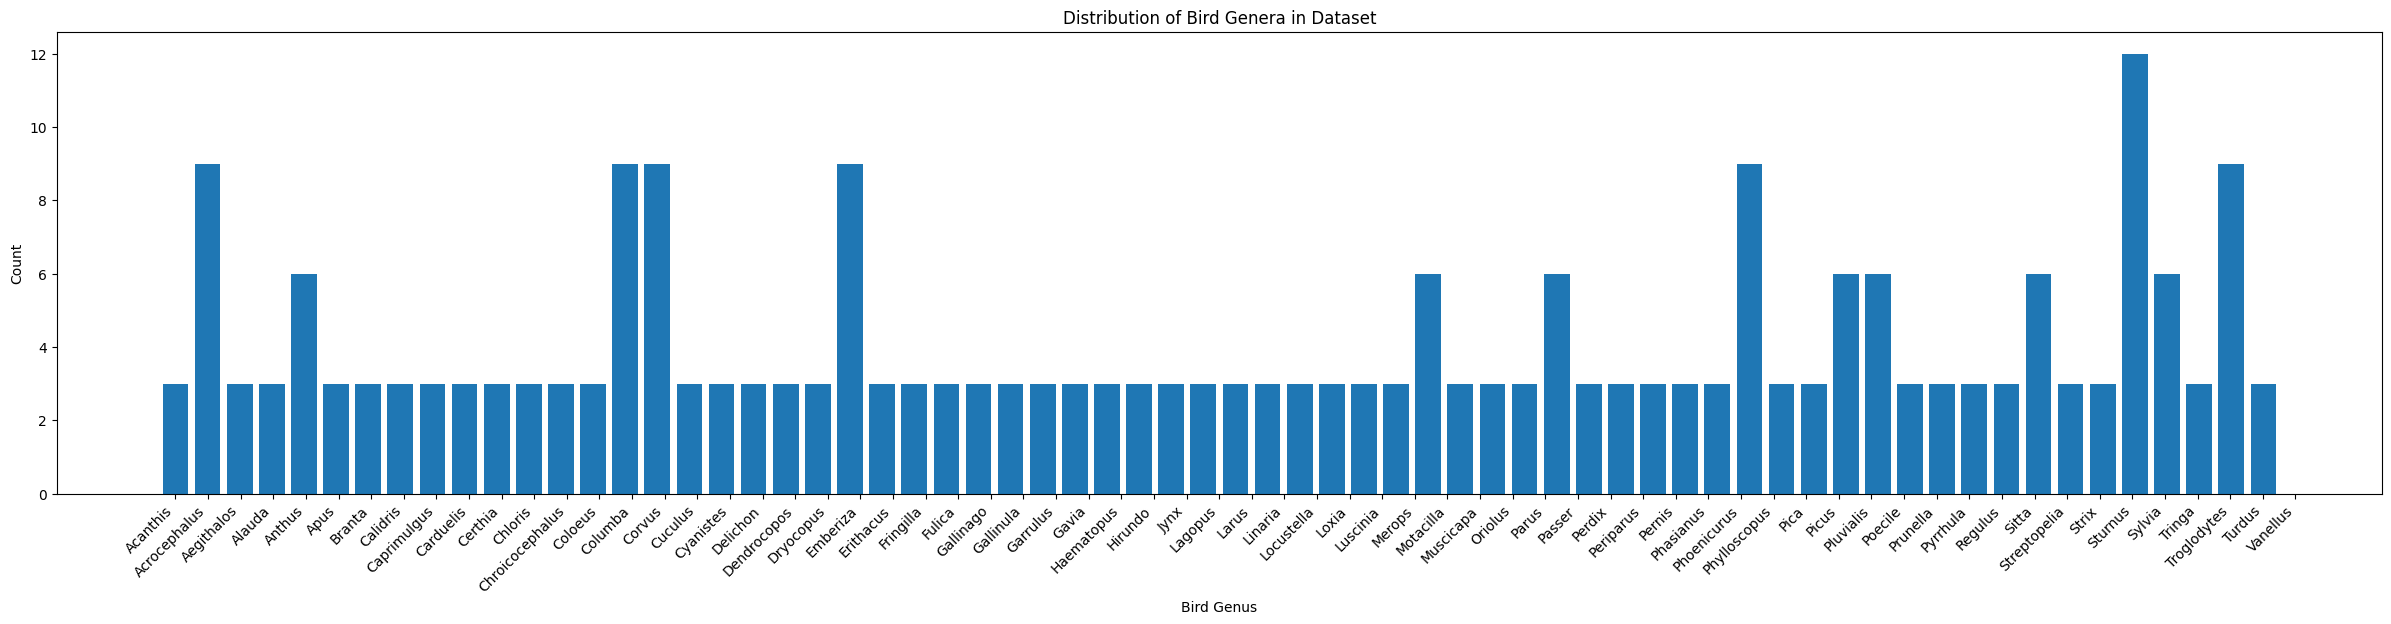

In [36]:
unique_labels = np.unique(labels)

plt.figure(figsize=(30, 6))
plt.hist(labels, bins=len(unique_labels), align='left', rwidth=0.8)
plt.xticks(unique_labels, unique_labels, rotation=45, ha='right')
plt.xlabel('Bird Genus')
plt.ylabel('Count')
plt.title('Distribution of Bird Genera in Dataset')
plt.show()


###Performance of CNN Models without Data Augmentation

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 371ms/step - accuracy: 0.0272 - loss: 22.4792 - val_accuracy: 0.0250 - val_loss: 5.5752
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0231 - loss: 9.5187 - val_accuracy: 0.0375 - val_loss: 4.3326
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0179 - loss: 6.3342 - val_accuracy: 0.0500 - val_loss: 4.1553
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0474 - loss: 4.9026 - val_accuracy: 0.0375 - val_loss: 4.1136
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0418 - loss: 4.4454 - val_accuracy: 0.0375 - val_loss: 4.1312
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0469 - loss: 4.4661 - val_accuracy: 0.0625 - val_loss: 4.1179
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0595 - loss: 4.1610 - val_accuracy: 0.0625 - val_loss: 4.0805
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0893 - loss: 4.1184 - val_accuracy: 0.0750 - val_loss: 4.06

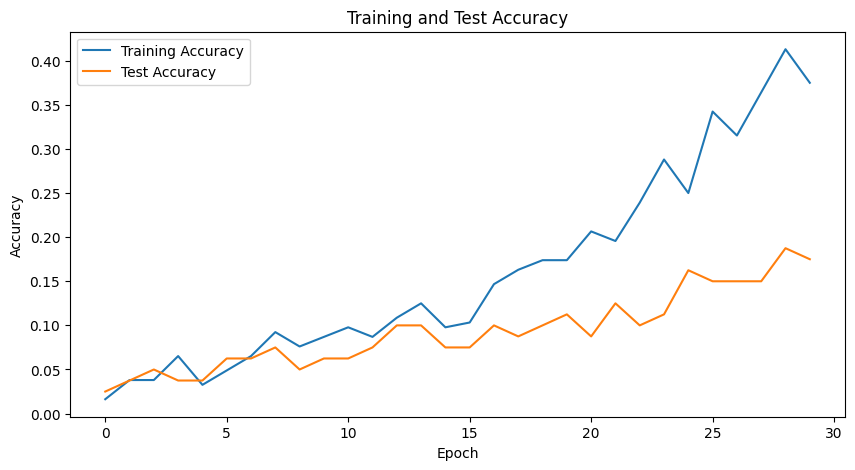

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_257 (Conv1D)                  │ (None, 40, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_71 (MaxPooling1D)      │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_258 (Conv1D)                  │ (None, 20, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_72 (MaxPooling1D)      │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 66)                  │          33,858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,144,072 (8.18 MB)

 Trainable params: 714,690 (2.73 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,429,382 (5.45 MB)

In [37]:
model_results = {}

model = CNN_1D(X_train,y_train)
train_acc, test_acc = train_CNN(model,X_train,y_train,X_test,y_test)
model_results["1D CNN"] = [train_acc, test_acc]



Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 372ms/step - accuracy: 0.0281 - loss: 6.4148 - val_accuracy: 0.0625 - val_loss: 4.7053
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.0506 - loss: 5.1058 - val_accuracy: 0.0250 - val_loss: 5.1930
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0831 - loss: 4.5975 - val_accuracy: 0.0250 - val_loss: 5.0181
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1106 - loss: 4.2409 - val_accuracy: 0.0375 - val_loss: 4.3505
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1362 - loss: 3.6375 - val_accuracy: 0.0375 - val_loss: 4.3672
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2109 - loss: 3.2985 - val_accuracy: 0.0750 - val_loss: 4.2066
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2069 - loss: 3.2182 - val_accuracy: 0.0375 - val_loss: 4.2040
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2556 - loss: 2.9794 - val_accuracy: 0.0625 -

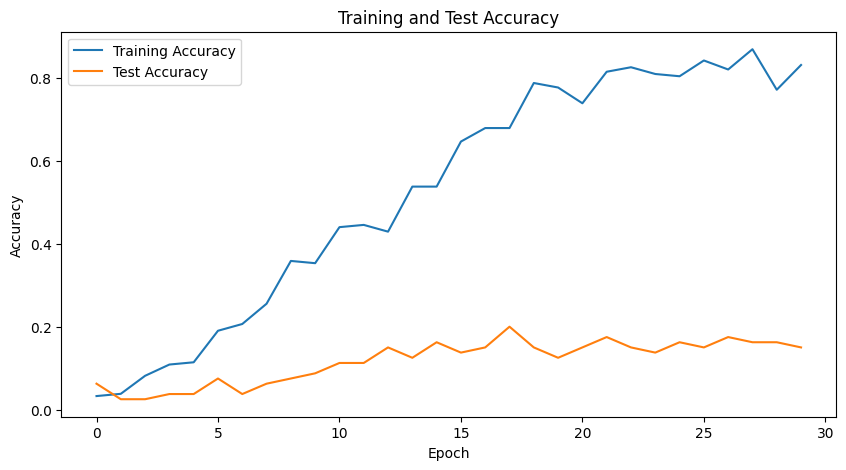

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_259 (Conv1D)                  │ (None, 36, 128)             │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 36, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_73 (MaxPooling1D)      │ (None, 35, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_260 (Conv1D)                  │ (None, 35, 256)             │         164,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 35, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_74 (MaxPooling1D)      │ (None, 17, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_261 (Conv1D)                  │ (None, 17, 256)             │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 17, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_262 (Conv1D)                  │ (None, 17, 256)             │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 17, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_263 (Conv1D)                  │ (None, 17, 256)             │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_37               │ (None, 17, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_75 (MaxPooling1D)      │ (None, 16, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 1024)                │       4,195,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 66)                  │          67,6

 Total params: 17,426,888 (66.48 MB)

 Trainable params: 5,808,194 (22.16 MB)

 Non-trainable params: 2,304 (9.00 KB)

 Optimizer params: 11,616,390 (44.31 MB)

In [38]:
model = alexNet(X_train,y_train)
train_acc, test_acc = train_CNN(model,X_train,y_train,X_test,y_test)
model_results["AlexNet"] = [train_acc, test_acc]

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.0106 - loss: 4.3160 - val_accuracy: 0.0375 - val_loss: 4.1663
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.0235 - loss: 4.1404 - val_accuracy: 0.0375 - val_loss: 4.1436
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.0571 - loss: 4.0198 - val_accuracy: 0.0500 - val_loss: 4.1533
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.0489 - loss: 4.0738 - val_accuracy: 0.0250 - val_loss: 4.1360
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.0602 - loss: 3.9056 - val_accuracy: 0.0250 - val_loss: 4.1483
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0803 - loss: 3.8439 - val_accuracy: 0.0500 - val_loss: 4.1268
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.0879 - loss: 3.8283 - val_accuracy: 0.0250 - val_loss: 4.1285
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.1207 - loss: 3.4883 - val_accuracy: 0.0375 - va

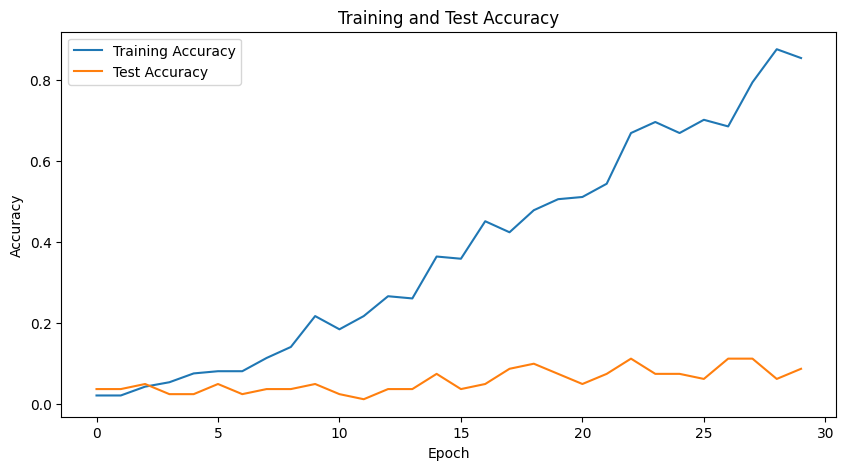

Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 40, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_264 (Conv1D)       │ (None, 40, 64)         │            384 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_38    │ (None, 40, 64)         │            256 │ conv1d_264[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_76          │ (None, 40, 64)         │              0 │ batch_normalization_3… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_265 (Conv1D)       │ (None, 40, 64)         │          4,160 │ max_pooling1d_76[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_266 (Conv1D)       │ (None, 40, 192)        │         37,056 │ conv1d_265[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_39    │ (None, 40, 192)        │            768 │ conv1d_266[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_77          │ (None, 40, 192)        │              0 │ batch_normalization_3… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_268 (Conv1D)       │ (None, 40, 96)         │         18,528 │ max_pooling1d_77[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_270 (Conv1D)       │ (None, 40, 16)         │          3,088 │ max_pooling1d_77[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_78          │ (None, 40, 192)        │              0 │ max_pooling1d_77[0][0] │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_267 (Conv1D)       │ (None, 40, 64)         │         12,352 │ max_pooling1d_77[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_269 (Conv1D)       │ (None, 40, 128)        │         36,992 │ conv1d_268[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_271 (Conv1D)       │ (None, 40, 32)         │          2,592 │ conv1d_270[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_272 (Conv1D)       │ (None, 40, 32)         │          6,176 │ max_pooling1d_78[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_36            │ (None, 40, 256)        │              0 │ conv1d_267[0][0],      │
│ (Concatenate)             │                        │                │ conv1d_269[0][0],      │
│                      

 Total params: 18,374,872 (70.09 MB)

 Trainable params: 6,124,786 (23.36 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 12,249,574 (46.73 MB)

In [39]:
model = GoogLeNet(X_train,y_train)
train_acc, test_acc = train_CNN(model,X_train,y_train,X_test,y_test)
model_results["GoogLeNet"] = [train_acc, test_acc]

In [40]:
features, labels = augment_data(features, labels)

Features shape before augmentation: (264, 40)
Labels shape before augmentation: (264,)
Augmented features shape: (792, 40)
Augmented labels shape: (792,)


In [41]:
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_onehot = to_categorical(labels_encoded)

X_train, X_test, y_train, y_test = train_test_split(features, labels_onehot, test_size=0.3, random_state=42, stratify=labels_onehot)

###Performance of CNN Models with Data Augmentation

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.0124 - loss: 21.4618 - val_accuracy: 0.0168 - val_loss: 4.2470
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0153 - loss: 5.4042 - val_accuracy: 0.0462 - val_loss: 4.1338
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0283 - loss: 4.5407 - val_accuracy: 0.0378 - val_loss: 4.1065
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0316 - loss: 4.2551 - val_accuracy: 0.0714 - val_loss: 4.0681
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0546 - loss: 4.1530 - val_accuracy: 0.0504 - val_loss: 4.0514
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0427 - loss: 4.1332 - val_accuracy: 0.0840 - val_loss: 4.0122
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0743 - loss: 4.0652 - val_accuracy: 0.0756 - val_loss: 3.9602
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0436 - loss: 4.0803 - val_accuracy: 0.0924 - val_loss: 3.9027
E

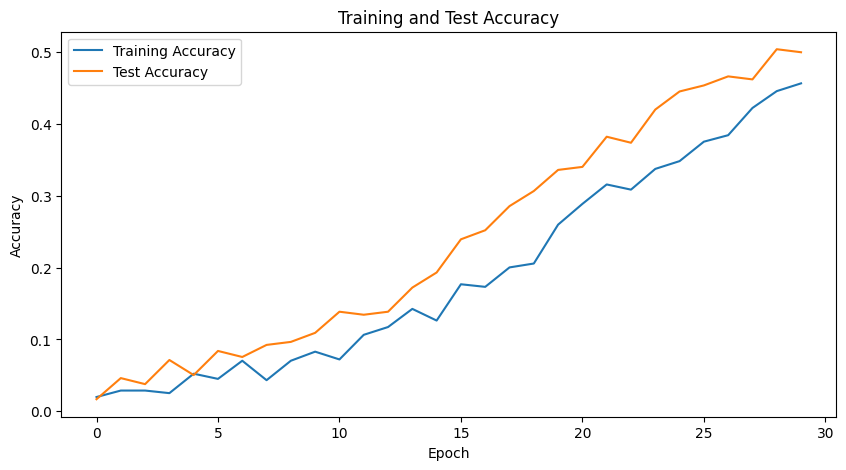

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_321 (Conv1D)                  │ (None, 40, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_89 (MaxPooling1D)      │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_322 (Conv1D)                  │ (None, 20, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_90 (MaxPooling1D)      │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 66)                  │          33,858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,144,072 (8.18 MB)

 Trainable params: 714,690 (2.73 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,429,382 (5.45 MB)

In [42]:
model = CNN_1D(X_train,y_train)
train_acc, test_acc = train_CNN(model,X_train,y_train,X_test,y_test)
model_results["DA_1D CNN"] = [train_acc, test_acc]

Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.0443 - loss: 6.5261 - val_accuracy: 0.0462 - val_loss: 4.4136
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0429 - loss: 4.5559 - val_accuracy: 0.0462 - val_loss: 4.1032
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0347 - loss: 4.2568 - val_accuracy: 0.0084 - val_loss: 4.1015
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0284 - loss: 4.1688 - val_accuracy: 0.0504 - val_loss: 3.9597
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0609 - loss: 3.9579 - val_accuracy: 0.1008 - val_loss: 3.9888
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0663 - loss: 3.9099 - val_accuracy: 0.1050 - val_loss: 3.7806
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0749 - loss: 3.9336 - val_accuracy: 0.1092 - val_loss: 3.7057
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0988 - loss: 3.7665 - val_accuracy: 0.1597 - val_lo

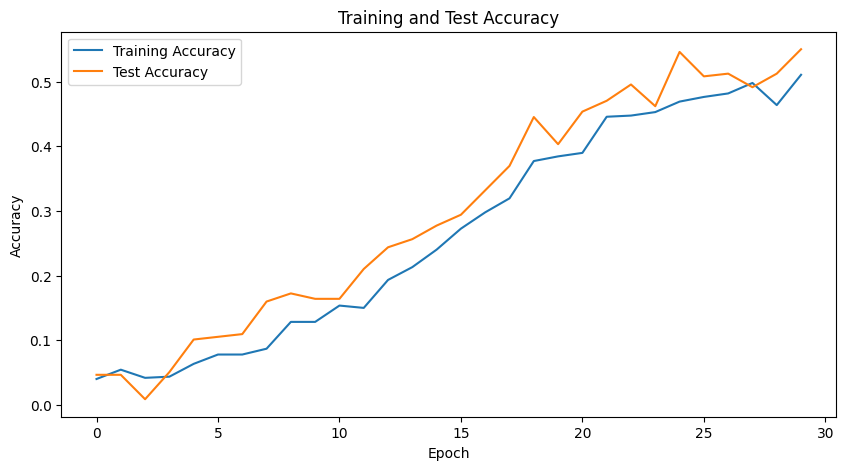

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_323 (Conv1D)                  │ (None, 36, 128)             │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_40               │ (None, 36, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_91 (MaxPooling1D)      │ (None, 35, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_324 (Conv1D)                  │ (None, 35, 256)             │         164,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_41               │ (None, 35, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_92 (MaxPooling1D)      │ (None, 17, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_325 (Conv1D)                  │ (None, 17, 256)             │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_42               │ (None, 17, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_326 (Conv1D)                  │ (None, 17, 256)             │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_43               │ (None, 17, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_327 (Conv1D)                  │ (None, 17, 256)             │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_44               │ (None, 17, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_93 (MaxPooling1D)      │ (None, 16, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 1024)                │       4,195,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 66)                  │          67,6

 Total params: 17,426,888 (66.48 MB)

 Trainable params: 5,808,194 (22.16 MB)

 Non-trainable params: 2,304 (9.00 KB)

 Optimizer params: 11,616,390 (44.31 MB)

In [43]:
model = alexNet(X_train,y_train)
train_acc, test_acc = train_CNN(model,X_train,y_train,X_test,y_test)
model_results["DA_AlexNet"] = [train_acc, test_acc]

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - accuracy: 0.0298 - loss: 6.4089 - val_accuracy: 0.0546 - val_loss: 4.2575
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0279 - loss: 4.5718 - val_accuracy: 0.0420 - val_loss: 4.1299
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0484 - loss: 4.2561 - val_accuracy: 0.0588 - val_loss: 4.0535
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0822 - loss: 4.0841 - val_accuracy: 0.0630 - val_loss: 4.0696
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0481 - loss: 4.0437 - val_accuracy: 0.0924 - val_loss: 3.9625
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0882 - loss: 3.8849 - val_accuracy: 0.0924 - val_loss: 3.8970
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1023 - loss: 3.8527 - val_accuracy: 0.1387 - val_loss: 3.7970
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1091 - loss: 3.7627 - val_accuracy: 0.1092 - val_l

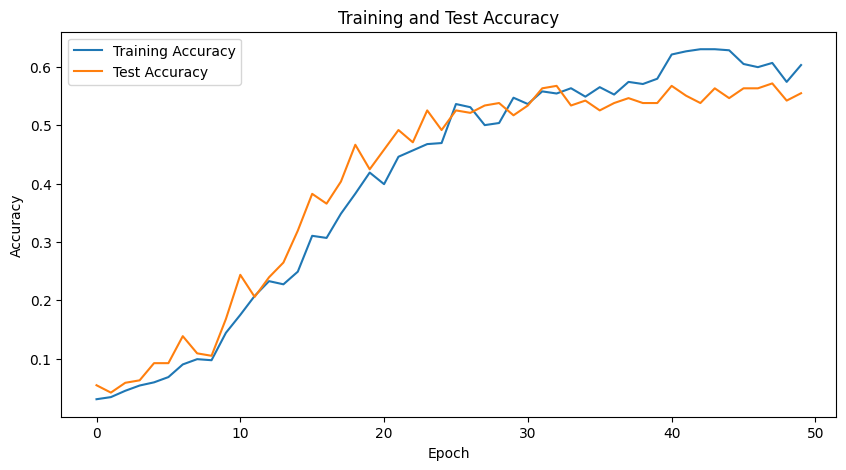

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_328 (Conv1D)                  │ (None, 36, 128)             │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_45               │ (None, 36, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_94 (MaxPooling1D)      │ (None, 35, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_329 (Conv1D)                  │ (None, 35, 256)             │         164,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_46               │ (None, 35, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_95 (MaxPooling1D)      │ (None, 17, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_330 (Conv1D)                  │ (None, 17, 256)             │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_47               │ (None, 17, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_331 (Conv1D)                  │ (None, 17, 256)             │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_48               │ (None, 17, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_332 (Conv1D)                  │ (None, 17, 256)             │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_49               │ (None, 17, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_96 (MaxPooling1D)      │ (None, 16, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_16 (Flatten)                 │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 1024)                │       4,195,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 66)                  │          67,6

 Total params: 17,426,888 (66.48 MB)

 Trainable params: 5,808,194 (22.16 MB)

 Non-trainable params: 2,304 (9.00 KB)

 Optimizer params: 11,616,390 (44.31 MB)

In [44]:
model = alexNet(X_train,y_train)
train_acc, test_acc = train_CNN(model,X_train,y_train,X_test,y_test,epochs=50)
model_results["DA_AlexNet(epochs=50)"] = [train_acc, test_acc]

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 178ms/step - accuracy: 0.0227 - loss: 5.6543 - val_accuracy: 0.0588 - val_loss: 4.1414
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0676 - loss: 4.4247 - val_accuracy: 0.0672 - val_loss: 4.1028
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0756 - loss: 4.1044 - val_accuracy: 0.1050 - val_loss: 4.0404
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0994 - loss: 3.8638 - val_accuracy: 0.1513 - val_loss: 3.9445
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2039 - loss: 3.4791 - val_accuracy: 0.1891 - val_loss: 3.7803
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2354 - loss: 3.2119 - val_accuracy: 0.2983 - val_loss: 3.6047
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2579 - loss: 3.1653 - val_accuracy: 0.3529 - val_loss: 3.3775
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3494 - loss: 2.8928 - val_accuracy: 0.3739 - val_l

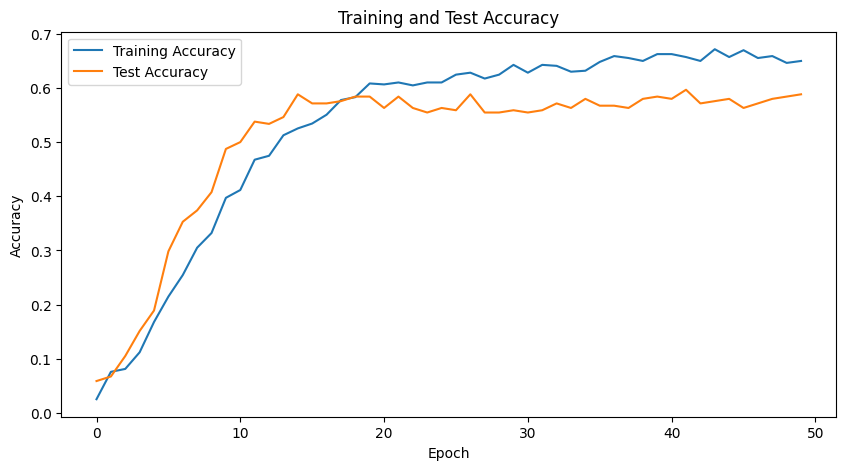

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_333 (Conv1D)                  │ (None, 36, 128)             │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_50               │ (None, 36, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_97 (MaxPooling1D)      │ (None, 35, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_334 (Conv1D)                  │ (None, 35, 256)             │         164,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_51               │ (None, 35, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_98 (MaxPooling1D)      │ (None, 17, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_335 (Conv1D)                  │ (None, 17, 256)             │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_52               │ (None, 17, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_336 (Conv1D)                  │ (None, 17, 256)             │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_53               │ (None, 17, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_337 (Conv1D)                  │ (None, 17, 256)             │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_54               │ (None, 17, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_99 (MaxPooling1D)      │ (None, 16, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_17 (Flatten)                 │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 1024)                │       4,195,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 66)                  │          67,6

 Total params: 17,426,888 (66.48 MB)

 Trainable params: 5,808,194 (22.16 MB)

 Non-trainable params: 2,304 (9.00 KB)

 Optimizer params: 11,616,390 (44.31 MB)

In [45]:
model = alexNet(X_train,y_train)
train_acc, test_acc = train_CNN(model,X_train,y_train,X_test,y_test,epochs=50, lr=0.0001)
model_results["DA_AlexNet(epochs=50, lr=0.0001)"] = [train_acc, test_acc]

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 0.0255 - loss: 5.5148 - val_accuracy: 0.0546 - val_loss: 4.1363
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.0637 - loss: 4.3384 - val_accuracy: 0.0672 - val_loss: 4.1002
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0989 - loss: 3.9484 - val_accuracy: 0.1050 - val_loss: 4.0208
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1247 - loss: 3.7984 - val_accuracy: 0.1345 - val_loss: 3.9258
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1851 - loss: 3.5549 - val_accuracy: 0.1933 - val_loss: 3.7682
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1824 - loss: 3.3716 - val_accuracy: 0.2773 - val_loss: 3.5818
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2682 - loss: 3.1125 - val_accuracy: 0.3361 - val_loss: 3.3211
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3262 - loss: 2.8140 - val_accuracy: 0.3655 - val_lo

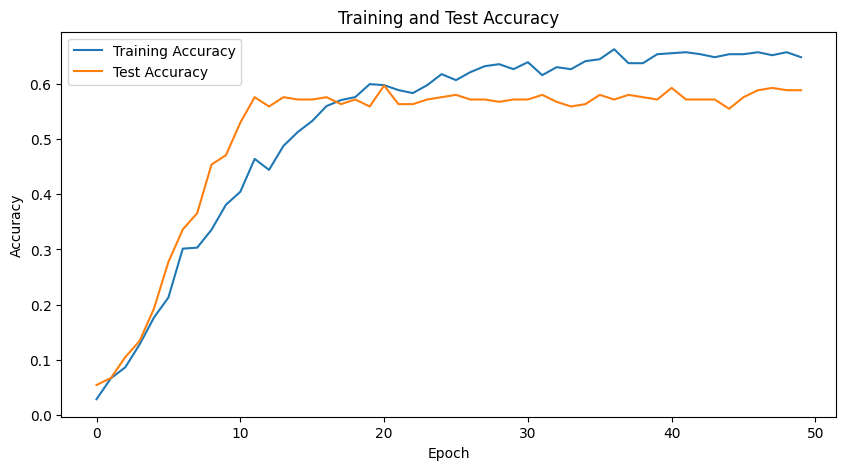

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_338 (Conv1D)                  │ (None, 36, 128)             │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_55               │ (None, 36, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_100 (MaxPooling1D)     │ (None, 35, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_339 (Conv1D)                  │ (None, 35, 256)             │         164,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_56               │ (None, 35, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_101 (MaxPooling1D)     │ (None, 17, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_340 (Conv1D)                  │ (None, 17, 256)             │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_57               │ (None, 17, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_341 (Conv1D)                  │ (None, 17, 256)             │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_58               │ (None, 17, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_342 (Conv1D)                  │ (None, 17, 256)             │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_59               │ (None, 17, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_102 (MaxPooling1D)     │ (None, 16, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_18 (Flatten)                 │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 1024)                │       4,195,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 66)                  │          67,6

 Total params: 11,618,694 (44.32 MB)

 Trainable params: 5,808,194 (22.16 MB)

 Non-trainable params: 2,304 (9.00 KB)

 Optimizer params: 5,808,196 (22.16 MB)

In [46]:
model = alexNet(X_train,y_train)
train_acc, test_acc = train_CNN(model,X_train,y_train,X_test,y_test,epochs=50, lr=0.0001,rmsprop=True)
model_results["DA_AlexNet(epochs=50, lr=0.0001, RMSProp)"] = [train_acc, test_acc]

Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 53s 589ms/step - accuracy: 0.0297 - loss: 4.2633 - val_accuracy: 0.0462 - val_loss: 4.1035
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.0503 - loss: 4.1023 - val_accuracy: 0.0462 - val_loss: 4.0880
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0487 - loss: 4.0899 - val_accuracy: 0.0210 - val_loss: 4.0888
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0460 - loss: 4.0976 - val_accuracy: 0.0588 - val_loss: 4.0938
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.0456 - loss: 4.0662 - val_accuracy: 0.0462 - val_loss: 4.0694
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.0632 - loss: 4.0506 - val_accuracy: 0.0588 - val_loss: 4.0008
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.0639 - loss: 3.9345 - val_accuracy: 0.1008 - val_loss: 3.9130
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0648 - loss: 3.8921 - val_accuracy: 0.0588 -

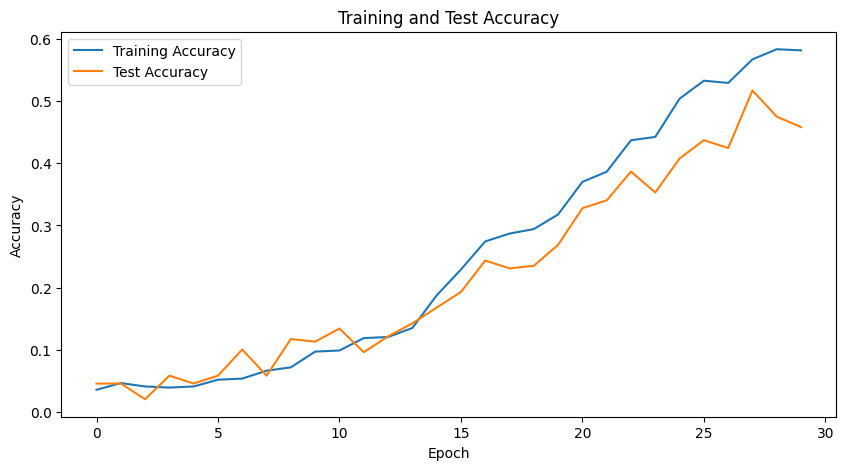

Model: "functional_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22            │ (None, 40, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_514 (Conv1D)       │ (None, 40, 64)         │            384 │ input_layer_22[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_66    │ (None, 40, 64)         │            256 │ conv1d_514[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_142         │ (None, 40, 64)         │              0 │ batch_normalization_6… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_515 (Conv1D)       │ (None, 40, 64)         │          4,160 │ max_pooling1d_142[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_516 (Conv1D)       │ (None, 40, 192)        │         37,056 │ conv1d_515[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_67    │ (None, 40, 192)        │            768 │ conv1d_516[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_143         │ (None, 40, 192)        │              0 │ batch_normalization_6… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_518 (Conv1D)       │ (None, 40, 96)         │         18,528 │ max_pooling1d_143[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_520 (Conv1D)       │ (None, 40, 16)         │          3,088 │ max_pooling1d_143[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_144         │ (None, 40, 192)        │              0 │ max_pooling1d_143[0][… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_517 (Conv1D)       │ (None, 40, 64)         │         12,352 │ max_pooling1d_143[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_519 (Conv1D)       │ (None, 40, 128)        │         36,992 │ conv1d_518[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_521 (Conv1D)       │ (None, 40, 32)         │          2,592 │ conv1d_520[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_522 (Conv1D)       │ (None, 40, 32)         │          6,176 │ max_pooling1d_144[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_72            │ (None, 40, 256)        │              0 │ conv1d_517[0][0],      │
│ (Concatenate)             │                        │                │ conv1d_519[0][0],      │
│                      

 Total params: 18,374,872 (70.09 MB)

 Trainable params: 6,124,786 (23.36 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 12,249,574 (46.73 MB)

In [51]:
model = GoogLeNet(X_train,y_train)
train_acc, test_acc = train_CNN(model,X_train,y_train,X_test,y_test)
model_results["DA_GoogleNet"] = [train_acc, test_acc]

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 53s 592ms/step - accuracy: 0.0167 - loss: 4.1968 - val_accuracy: 0.0462 - val_loss: 4.1189
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.0620 - loss: 4.0793 - val_accuracy: 0.0462 - val_loss: 4.1103
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0622 - loss: 4.0319 - val_accuracy: 0.0462 - val_loss: 4.1068
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0640 - loss: 3.9947 - val_accuracy: 0.0882 - val_loss: 4.0555
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0985 - loss: 3.7977 - val_accuracy: 0.0966 - val_loss: 3.9860
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.1489 - loss: 3.5525 - val_accuracy: 0.1008 - val_loss: 3.8100
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2452 - loss: 3.1159 - val_accuracy: 0.1345 - val_loss: 3.6799
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3036 - loss: 2.7338 - val_accuracy: 0.2227 -

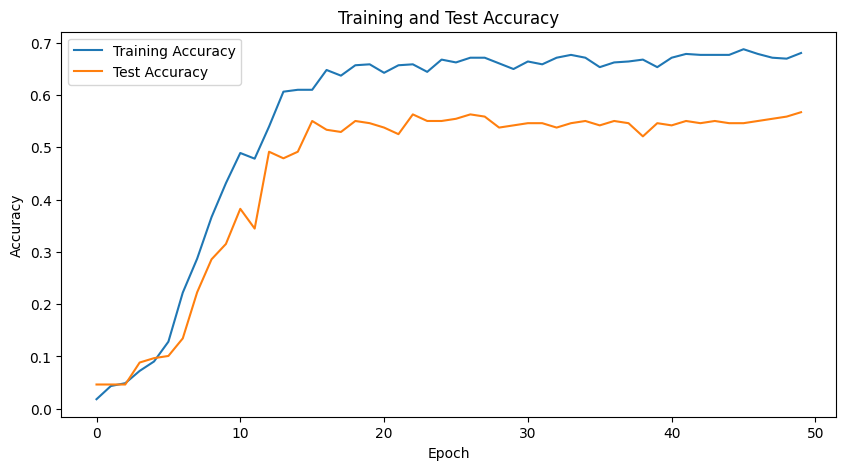

Model: "functional_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20            │ (None, 40, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_400 (Conv1D)       │ (None, 40, 64)         │            384 │ input_layer_20[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_62    │ (None, 40, 64)         │            256 │ conv1d_400[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_116         │ (None, 40, 64)         │              0 │ batch_normalization_6… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_401 (Conv1D)       │ (None, 40, 64)         │          4,160 │ max_pooling1d_116[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_402 (Conv1D)       │ (None, 40, 192)        │         37,056 │ conv1d_401[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_63    │ (None, 40, 192)        │            768 │ conv1d_402[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_117         │ (None, 40, 192)        │              0 │ batch_normalization_6… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_404 (Conv1D)       │ (None, 40, 96)         │         18,528 │ max_pooling1d_117[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_406 (Conv1D)       │ (None, 40, 16)         │          3,088 │ max_pooling1d_117[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_118         │ (None, 40, 192)        │              0 │ max_pooling1d_117[0][… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_403 (Conv1D)       │ (None, 40, 64)         │         12,352 │ max_pooling1d_117[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_405 (Conv1D)       │ (None, 40, 128)        │         36,992 │ conv1d_404[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_407 (Conv1D)       │ (None, 40, 32)         │          2,592 │ conv1d_406[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_408 (Conv1D)       │ (None, 40, 32)         │          6,176 │ max_pooling1d_118[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_54            │ (None, 40, 256)        │              0 │ conv1d_403[0][0],      │
│ (Concatenate)             │                        │                │ conv1d_405[0][0],      │
│                      

 Total params: 18,374,872 (70.09 MB)

 Trainable params: 6,124,786 (23.36 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 12,249,574 (46.73 MB)

In [48]:
model = GoogLeNet(X_train,y_train)
train_acc, test_acc = train_CNN(model,X_train,y_train,X_test,y_test,epochs=50, lr=0.0001)
model_results["DA_GoogleNet_(epochs=50, lr=0.0001)"] = [train_acc, test_acc]

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 45s 534ms/step - accuracy: 0.0366 - loss: 4.1733 - val_accuracy: 0.0462 - val_loss: 4.1269
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0448 - loss: 4.0602 - val_accuracy: 0.0462 - val_loss: 4.0935
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0566 - loss: 4.0229 - val_accuracy: 0.0504 - val_loss: 4.0787
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0614 - loss: 3.9823 - val_accuracy: 0.0882 - val_loss: 4.0814
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.1003 - loss: 3.8798 - val_accuracy: 0.1008 - val_loss: 3.9870
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.1193 - loss: 3.6974 - val_accuracy: 0.0672 - val_loss: 3.9493
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1192 - loss: 3.5265 - val_accuracy: 0.1345 - val_loss: 3.7288
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2061 - loss: 3.1235 - val_accuracy: 0.1933 -

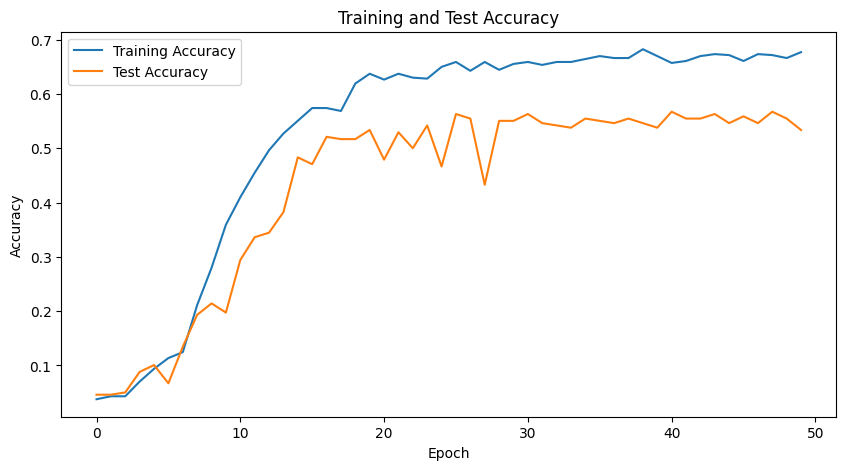

Model: "functional_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21            │ (None, 40, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_457 (Conv1D)       │ (None, 40, 64)         │            384 │ input_layer_21[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_64    │ (None, 40, 64)         │            256 │ conv1d_457[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_129         │ (None, 40, 64)         │              0 │ batch_normalization_6… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_458 (Conv1D)       │ (None, 40, 64)         │          4,160 │ max_pooling1d_129[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_459 (Conv1D)       │ (None, 40, 192)        │         37,056 │ conv1d_458[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_65    │ (None, 40, 192)        │            768 │ conv1d_459[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_130         │ (None, 40, 192)        │              0 │ batch_normalization_6… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_461 (Conv1D)       │ (None, 40, 96)         │         18,528 │ max_pooling1d_130[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_463 (Conv1D)       │ (None, 40, 16)         │          3,088 │ max_pooling1d_130[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_131         │ (None, 40, 192)        │              0 │ max_pooling1d_130[0][… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_460 (Conv1D)       │ (None, 40, 64)         │         12,352 │ max_pooling1d_130[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_462 (Conv1D)       │ (None, 40, 128)        │         36,992 │ conv1d_461[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_464 (Conv1D)       │ (None, 40, 32)         │          2,592 │ conv1d_463[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_465 (Conv1D)       │ (None, 40, 32)         │          6,176 │ max_pooling1d_131[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_63            │ (None, 40, 256)        │              0 │ conv1d_460[0][0],      │
│ (Concatenate)             │                        │                │ conv1d_462[0][0],      │
│                      

 Total params: 12,250,086 (46.73 MB)

 Trainable params: 6,124,786 (23.36 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 6,124,788 (23.36 MB)

In [49]:
model = GoogLeNet(X_train,y_train)
train_acc, test_acc = train_CNN(model,X_train,y_train,X_test,y_test,epochs=50, lr=0.0001,rmsprop=True)
model_results["DA_GoogleNet(epochs = 50,lr=0.0001, RMSProp)"] = [train_acc, test_acc]

###Experimental Result Comparison

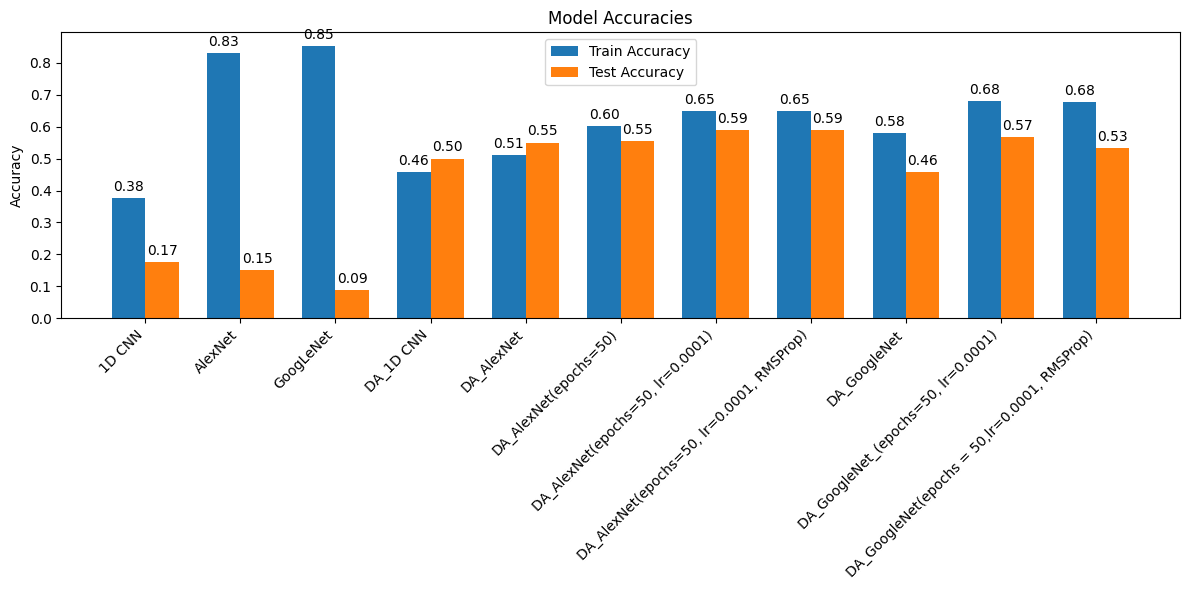

In [52]:
models = list(model_results.keys())
train_accuracies = [result[0] for result in model_results.values()]
test_accuracies = [result[1] for result in model_results.values()]

x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))  # Adjust figure size
rects1 = ax.bar(x - width/2, train_accuracies, width, label='Train Accuracy')
rects2 = ax.bar(x + width/2, test_accuracies, width, label='Test Accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracies')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')  # Rotate x-axis labels
ax.legend()

# Function to add labels to the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),  # Format to 2 decimal places
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

This project provided valuable insights into the application of CNN architectures for audio classification, particularly in handling limited datasets. A key takeaway was the impact of data augmentation in mitigating overfitting, as models trained without it suffered from extremely low test accuracy. Extending training epochs and lowering the learning rate contributed to better model convergence, but gains were not always substantial beyond a certain point, highlighting the need for hyperparameter optimization.
The comparison between Adam and RMSprop showed that while Adam provided stable optimization across models, RMSprop was beneficial for deeper architectures like GoogLeNet. This suggests that optimizer selection should be architecture-dependent. Additionally, the study confirmed that AlexNet was more parameter-efficient in 1D than GoogLeNet, which contrasts with their typical performance in 2D applications, demonstrating the importance of tailoring architectures for specific input types.
Another key learning was that training complexity should be balanced with computational efficiency. While GoogLeNet had the highest parameter count, its performance gains were only marginal compared to AlexNet, indicating diminishing returns for deeper architectures when working with small datasets. These findings reinforce the necessity of systematic experimentation and fine-tuning to optimize model performance.
